In [0]:
#Crear una variable url para asignar la ruta url del archivo csv de entrenamiento guardado en mi github
url = 'https://raw.githubusercontent.com/javalillo13689/tesst/master/train.csv'

#Importaremos el url de nuestra data para hacer el test.
url_2 ='https://raw.githubusercontent.com/javalillo13689/tesst/master/test.csv'

#Importar la librería pandas para trabajar con dataframes y guardar esta libreria como una variable pd
import pandas as pd
import numpy as np
import seaborn as sns

#Crear una variable train para guardar la data de entrenamiento a partir del archivo csv obteniendo así un dataframe
#El índice del dataframe serán los valores que aparecen en la columna Id del archivo csv
train = pd.read_csv(url, index_col='Id')
test = pd.read_csv(url_2, index_col='Id')

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [0]:
train.head(2)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [0]:
#Crear una variable list_1 para asignar una lista con los nombres de las columnas descritas
list_1=['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology']

### Haremos un rápido feature engineer de distancia pitagórica.

In [0]:
#Importar la libreria math para trabajar con funciones matemáticas
import math

#Definimos una funcion que denominamos pitagoras con dos parámetros que sacará la raíz cuadrada de la suma de los cuadrados de ambos parámetros
def pitagoras (a, b): 
    return math.sqrt(a**2 + b**2)

#Agregamos la columna pitagoras al dataframe train_pitagoras_distance1 donde guardar el resultado de ejecutar la función pitagoras fila por fila
train['pitagoras'] = train.apply(lambda row : pitagoras(row['Horizontal_Distance_To_Hydrology'],row['Vertical_Distance_To_Hydrology']), axis = 1)
#Tambien transformamos el test
test['pitagoras'] = test.apply(lambda row : pitagoras(row['Horizontal_Distance_To_Hydrology'],row['Vertical_Distance_To_Hydrology']),axis=1)

In [0]:
list_2=['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']
#Voy a sacar la media de las sombras de estas tres variables
train['hillmean'] = train[list_2].mean(axis=1) 
test['hillmean'] = test[list_2].mean(axis=1)

In [0]:
train.head(2)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,pitagoras,hillmean
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,258.000000,200.333333
2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,212.084889,202.000000


Tendremos que trabajar ahora con el test

In [0]:
#Crear una variable X para guardar un dataframe train2
X = train

In [0]:
#Crear una variable y para guardar solo la columna Cover_Type de la variable X porque esta variable es el objetivo de la predicción
y = X['Cover_Type']

#Eliminar la columna Cover_Type de la variable X para solo conservar las variables predictoras.
#El parámetro inplace=True permite actualizar la variable X
X.drop(['Cover_Type'], axis=1, inplace=True)

In [0]:
#Importamos la función train_test_split para poder usar model_selection
from sklearn.model_selection import train_test_split

#Usando train_test_split obtenemos las muestras de entrenamiento (train) y test a partir de X tomando el 60% y 40% respectivamente
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=0.4,random_state=0)

### Haremos tres modelos tuneando los hiperparámetros y buscando la combinación óptima

In [0]:
#Para tunear los hiperparámetros necesitamos importar GridSearchCV

from sklearn.model_selection import GridSearchCV

#Importamos la librería sklearn y model_selection para utilizar cross_val_score
from sklearn.model_selection import cross_val_score


### Regresion Logistica

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression() #Le pondré nombre a mi regresión

#Definiré el rango de parámetros en los que quiero buscar.
param_grid = {'C' : [*range(1,40,5)] }

#Encontraré el parámetro C óptimo:
searcher_logreg = GridSearchCV(logreg, param_grid) #Acá va a estar mi modelo con los parámetros tuneados

searcher_logreg.fit(X_train,y_train) #Entreno mis modelos y saco los mejores parámetros

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 6, 11, 16, 21, 26, 31, 36]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
searcher_logreg.best_params_

{'C': 31}

In [0]:
#Con lo siguiente seleccionamos el mejor de nuestros modelos
logreg_best = searcher_logreg.best_estimator_
#Evaluamos el performance de nuestor modelo junto con una validación cruzada
cross_val_score(logreg_best, X_train, y_train, cv=5)

array([0.65859031, 0.64867841, 0.67878788, 0.66280992, 0.6558011 ])

In [0]:
logreg_best.score(X_test,y_test)

0.660218253968254

### Random Forest 

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)

#Especificamos los parámetros en los que queremos buscar lo óptimo
params_rf = {'max_depth' : [6,11,12,13], 'criterion' : ['gini','entropy'] }

#Hacemos la búsqueda
searcher_rf = GridSearchCV(rf_clf, params_rf)

searcher_rf.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             i

In [0]:
searcher_rf.best_params_

{'criterion': 'entropy', 'max_depth': 13}

In [0]:
rf_clf_ = searcher_rf.best_estimator_


cross_val_score(rf_clf_, X_train, y_train, cv=5)

array([0.81497797, 0.8160793 , 0.8137741 , 0.82258953, 0.81546961])

In [0]:
rf_clf_.score(X_test,y_test)

0.8153108465608465

In [0]:
from sklearn.svm import SVC

svc_ = SVC()

params = {'C' : [1,2,4,5], 'kernel': ['linear','sigmoid']}

searcher_gcv = GridSearchCV(svc_,params,cv=3)

searcher_gcv.fit(X_train,y_train)

KeyboardInterrupt: ignored

In [0]:
X_train.shape

### AdaBoost

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#En este caso no tunaeremos nuestro adaboost
ab_clf = AdaBoostClassifier(learning_rate=1,
                            random_state=337,
                            base_estimator=DecisionTreeClassifier(max_depth=10))

ab_clf.fit(X_train,y_train)

cross_val_score(ab_clf, X_train, y_train, cv=5)

array([0.8034141 , 0.8034141 , 0.8214876 , 0.81322314, 0.81546961])

In [0]:
ab_clf.score(X_test,y_test)

0.8077050264550265

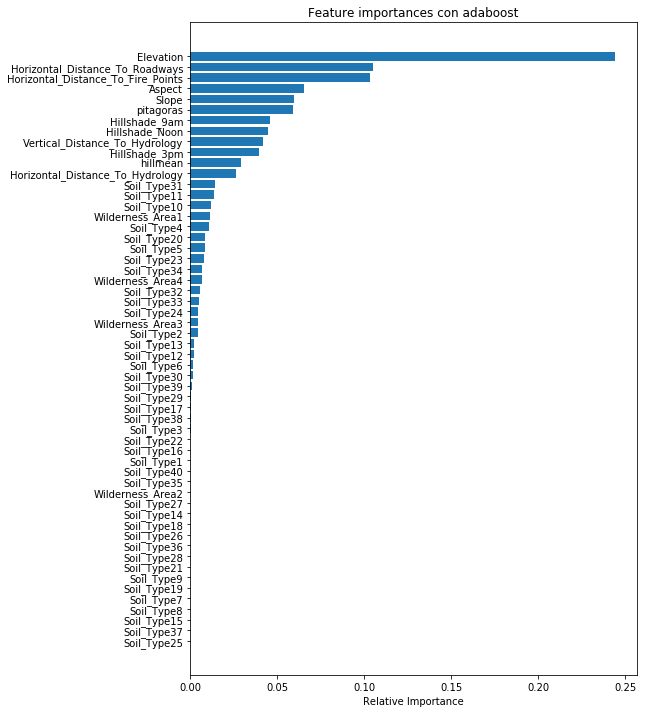

In [0]:
importances = ab_clf.feature_importances_
cols = X_train.columns
plt.figure(figsize=(8,12))
indices = np.argsort(importances)
plt.title('Feature importances con adaboost')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)),[cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Ensamblando los modelos

In [0]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('logreg',logreg_best),('rforest',rf_clf_),('adaboost',ab_clf)],voting='hard')

In [0]:
voting_clf.fit(X_train,y_train)
voting_clf.score(X_test,y_test)

0.8115079365079365

### XGBOOST 

In [0]:
#Importamos la librería xgboost para utilizar XGBClassifier utilizado en la predicción de clases (variables categóricas)
#En este ejemplo la clase de la variable Category_Type
from xgboost import XGBClassifier

#Creamos la variable xgb_c para guardar XGBClassifier
xgb_c = XGBClassifier(learning_rate = 0.1,
                      n_estimators = 500, 
                      early_stopping_rounds = 10, 
                      max_depth = 10,
                      eval_metric = 'logloss', 
                      eval_set =[(X_test,y_test)] )


In [0]:
X_train.shape

(9072, 56)

In [0]:
#Utilizamos los parámetros del modelo xgb_c para utilizar las muestras de entrenamiento
#El parámetro early_stopping_rounds indica el límite de iteraciones del modelo
#El parámetro eval_set indica una referencia para comparar los resultados de cada iteración del modelo
xgb_c.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              eval_metric='logloss',
              eval_set=[(       Elevation  Aspect  Slope  ...  Soil_Type40    pitagoras    hillmean
Id                               ...                                      
4429        2220      18     12  ...            0     0.000000  188.666667
12400       2139     119     10  ...            0     0.000000  198.000000
4648        2292     109     26  ...            0   215.564376  170.666667
5954        2345      92     13  ...            0     0.000000  1...
10675    6
9761     1
5801     6
10196    1
14070    1
11547    2
826      2
4987     4
9712     7
1142     1
Name: Cover_Type, Length: 6048, dtype: int64)],
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective

In [0]:
#Obtenemos las predicciones utilizando el parámetro predict del modelo xgb_c a partir del dataframe train4
#Creamos la variable predictions para guardar las predicciones
predictions = xgb_c.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(predictions,y_test)

0.8472222222222222

In [0]:
#Importamos la librería sklearn y model_selection para utilizar cross_val_score
from sklearn.model_selection import cross_val_score

#Usando cross_val_score iteramos el modelo xgb_c a partir de las muestras de entrenamiento
#El parámetro cv hace referencia a las particiones de las muestras de entrenamiento para las iteraciones
cross_val_score(xgb_c, X_train, y_train, cv=5)

array([0.85352423, 0.85737885, 0.85730028, 0.85013774, 0.84364641])

### LightGBM

In [0]:
import lightgbm as lgb
from sklearn.model_selection import KFold

d_train = lgb.Dataset(X_train, label=y_train)
folds = KFold(5, random_state=42)


params = {'task': 'train','boosting_type': 'gbdt','objective': 'binary','metric': { 'auc'}, "max_depth":2,
              "num_leaves":3,'learning_rate': 0.075,"min_child_samples": 100,'feature_fraction': 0.95,"bagging_freq":1,
              'bagging_fraction': 0.9,"lambda_l1":5,"lambda_l2":1,'verbose': 1}


lgb_clf = lgb.train(params, d_train, 100)

results = lgb.cv(params, d_train, folds=folds.split(X_train), num_boost_round=1000, 
                 early_stopping_rounds=100)



lgb_pred = lgb_clf.predict(X_test)



In [0]:
lgb_pred

array([1., 1., 1., ..., 1., 1., 1.])